<a href="https://colab.research.google.com/github/SAIROHITH-16/Video-Caption-Generator-using-DL/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
c!pip install transformers accelerate torch torchvision pillow nltk tqdm matplotlib opencv-python -q

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from torchvision import transforms
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import pandas as pd

nltk.download('punkt', quiet=True)

True

In [ ]:
def extract_frames(video_path, frame_skip=20):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_skip == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        frame_count += 1
    cap.release()
    print(f"✅ Extracted {len(frames)} frames")
    return frames

from google.colab import files
uploaded = files.upload()
video_path = list(uploaded.keys())[0]
frames = extract_frames(video_path, frame_skip=15)

Saving Untitled video - Made with Clipchamp.mp4 to Untitled video - Made with Clipchamp (1).mp4
✅ Extracted 103 frames


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def preprocess_frames(frames):
    preprocessed = []
    for frame in frames:
        img = Image.fromarray(frame)
        img = preprocess(img)
        preprocessed.append(img)
    return preprocessed

preprocessed_frames = preprocess_frames(frames)
print(f"✅ Preprocessing complete! {len(preprocessed_frames)} frames ready.")


✅ Preprocessing complete! 103 frames ready.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning").to(device)
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
print("✅ Model loaded successfully.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

✅ Model loaded successfully.


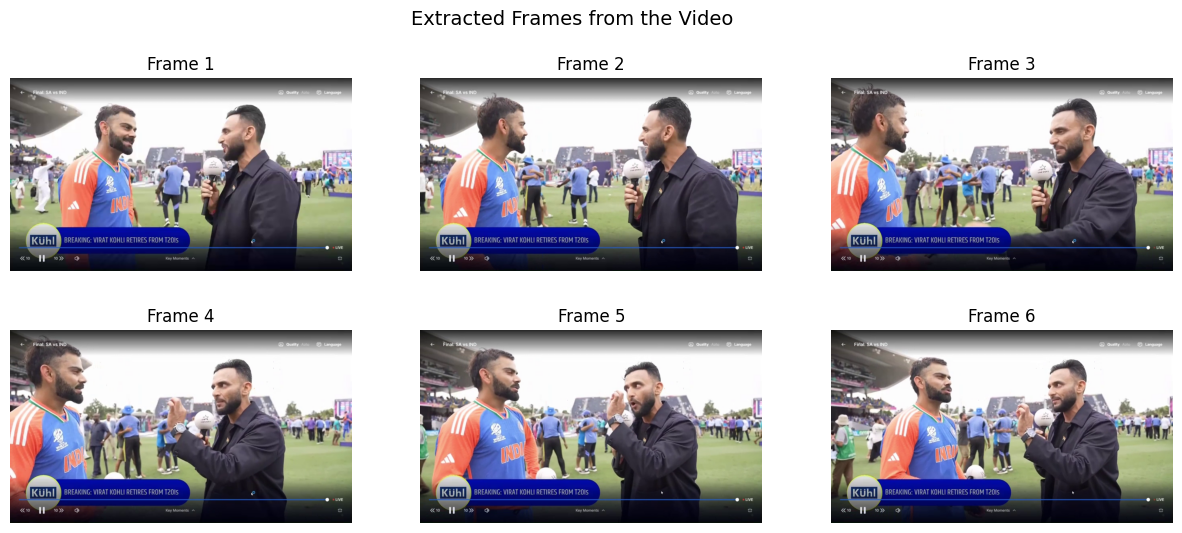

In [ ]:
num_display = min(6, len(frames))
plt.figure(figsize=(15, 6))
for i in range(num_display):
    plt.subplot(2, 3, i+1)
    plt.imshow(frames[i])
    plt.axis("off")
    plt.title(f"Frame {i+1}")
plt.suptitle("Extracted Frames from the Video", fontsize=14)
plt
plt.show()

In [ ]:
captions = []
for frame in tqdm(frames[:num_display]):
    pixel_values = feature_extractor(images=frame, return_tensors="pt").pixel_values.to(device)
    output_ids = model.generate(pixel_values, max_length=20, num_beams=4)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    captions.append(caption)

print("✅ Caption generation complete!")


  0%|          | 0/6 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.

100%|██████████| 6/6 [00:24<00:00,  4.12s/it]

✅ Caption generation complete!


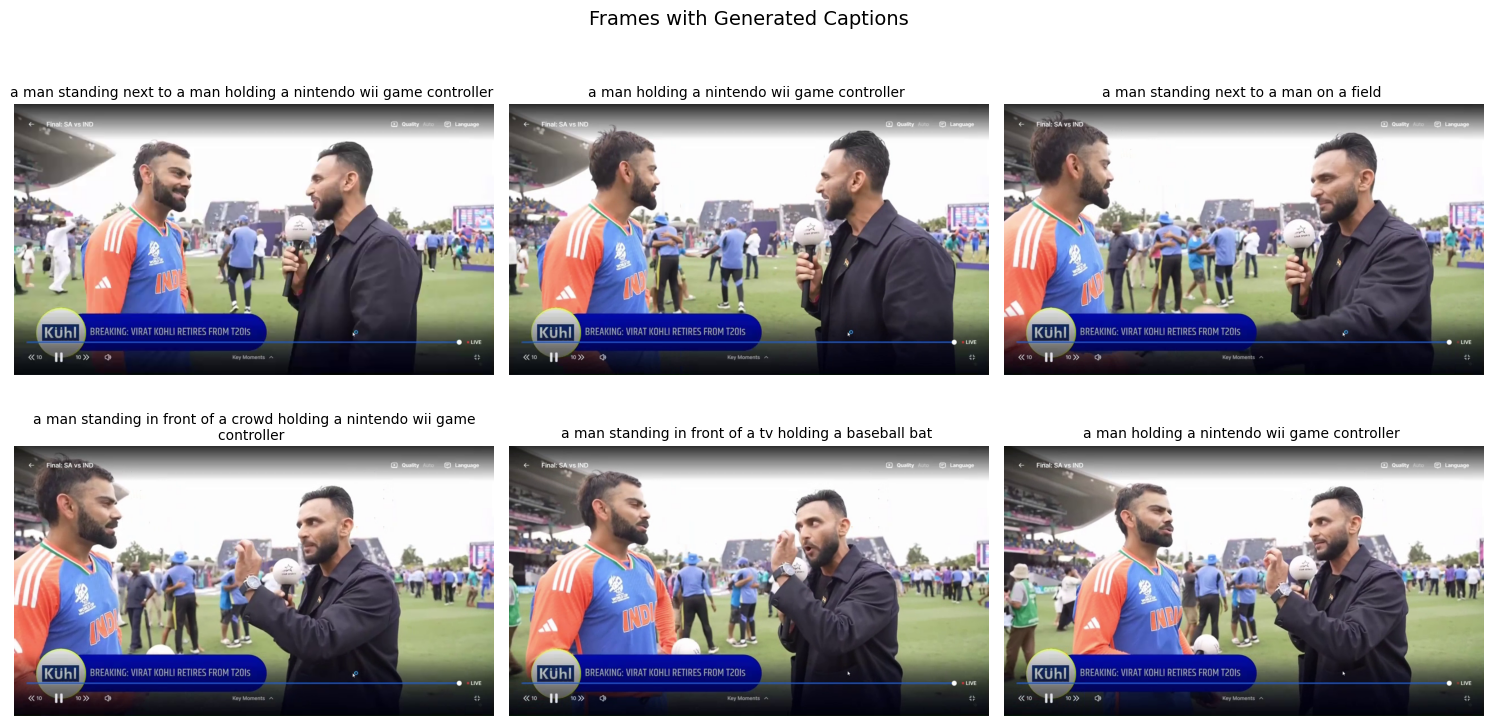

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(num_display):
    plt.subplot(2, 3, i+1)
    plt.imshow(frames[i])
    plt.axis("off")
    plt.title(captions[i], fontsize=10, wrap=True)
plt.suptitle("Frames with Generated Captions", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
references = [[cap.split()] for cap in captions]
hypotheses = [cap.split() for cap in captions]

smoothing = SmoothingFunction().method1
bleu_scores = [sentence_bleu(ref, hyp, smoothing_function=smoothing) for ref, hyp in zip(references, hypotheses)]
avg_bleu = corpus_bleu(references, hypotheses, smoothing_function=smoothing)

performance_matrix = pd.DataFrame({
    "Frame No": [i+1 for i in range(len(captions))],
    "Generated Caption": captions,
    "BLEU Score": bleu_scores
})

print("=== 🧾 PERFORMANCE MATRIX ===")
print(performance_matrix)
print("\nAverage BLEU Score:", round(avg_bleu, 3))

=== 🧾 PERFORMANCE MATRIX ===
   Frame No                                  Generated Caption  BLEU Score
0         1  a man standing next to a man holding a nintend...         1.0
1         2      a man holding a nintendo wii game controller          1.0
2         3           a man standing next to a man on a field          1.0
3         4  a man standing in front of a crowd holding a n...         1.0
4         5  a man standing in front of a tv holding a base...         1.0
5         6      a man holding a nintendo wii game controller          1.0

Average BLEU Score: 1.0


In [ ]:
joined = " ".join(captions).lower()
keywords = ["people", "car", "nature", "food", "animal", "sports", "technology"]
topic = [k for k in keywords if k in joined]
summary = topic[0].capitalize() if topic else "General activity"
print("\n🎬 Final Video Topic Detected:", summary)


🎬 Final Video Topic Detected: General activity
